### 🖼️ 🔤 Visual–Text Mis‑alignment Detection

This tool spots news items whose **image does not match the headline or body text**.

| What it does | Details |
|--------------|---------|
| **Inputs**   | Main image · headline · lead/body paragraph (8 EU languages) |
| **Outputs**  | `aligned` or `misaligned` + confidence (0–1) |
| **Model**    | Dual‑encoder (CLIP‑style) fine‑tuned on mis‑alignment pairs |
| **Goal**     | Surface misleading thumbnails, recycled photos, or click‑bait imagery |

**Notebook flow**

1. Batch‑send each article’s image + text to the API  
2. Collect predictions
3. Aggregate daily *Aligned vs Misaligned* counts  
4. Save `news_tool_multimodal_visual_text_misalignment_detection.json`  
5. Plot a stacked bar chart to visualise trends


In [ ]:
# ╔══════════════════════════════════════════════════════════════════════════╗
# ║  Multimodal Visual‑Text Mis‑alignment (MVTMD) – Full Analytics Notebook  ║
# ╚══════════════════════════════════════════════════════════════════════════╝
# ▸ Generates time‑series, global distribution, and language‑level plots
# ▸ Works from a fresh session – only needs TRINO_HOST, TRINO_USER, TRINO_CATALOG env‑vars

# ──────────────────────────────────────────────────────────────────────────
# 1 ▸ Install runtime dependencies (comment‑out after first run)
# ──────────────────────────────────────────────────────────────────────────
%pip install -q trino==0.332.0 trino[sqlalchemy] pandas matplotlib scikit-learn numpy


In [ ]:


# ──────────────────────────────────────────────────────────────────────────
# 2 ▸ Imports, Utilities & Plot Style
# ──────────────────────────────────────────────────────────────────────────
import os, re, warnings, json, datetime as dt
from pathlib import Path
from typing import Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors

from sklearn.metrics import precision_recall_curve, average_precision_score
from trino.dbapi import connect

# JSON helper functions
def _json_default(value):
    """JSON serializer for date/time objects (returns ISO format)."""
    if isinstance(value, (dt.datetime, dt.date)):
        return value.isoformat()
    return repr(value)

def save_dict(d: dict, path: Path):
    """Save a dictionary to a file in JSON format."""
    path.write_text(json.dumps(d, default=_json_default))

def load_dict(path: Path) -> dict:
    """Load a dictionary from a JSON file."""
    return json.loads(path.read_text())

# Host/port parser
def _parse_host_port(host: Optional[str], port: Optional[str], default_port: int = 8080) -> Tuple[str, int]:
    """Parse combined host and port information from environment variables."""
    host = (host or "").strip()
    port = (port or "").strip()
    # Remove protocol prefixes like http:// or tcp://
    host = re.sub(r"^(?:https?|tcp)://", "", host, flags=re.I)
    # If host string contains "host:port" and port is not given separately
    if ":" in host and not port:
        host, port = host.split(":", 1)
    # Extract port number or use default
    try:
        port_int = int(re.sub(r"\D", "", port))
    except ValueError:
        port_int = default_port
    # Ensure port is in a valid range; otherwise use default
    if not (1 <= port_int <= 65_535):
        port_int = default_port
    return host or "localhost", port_int

# Configure warnings and plot style
warnings.filterwarnings("ignore", category=RuntimeWarning)
plt.style.use("default")


In [ ]:

# ──────────────────────────────────────────────────────────────────────────
# 3 ▸ USER INPUTS – adjust freely
# ──────────────────────────────────────────────────────────────────────────
START_DATE   = "2025-03-01"
END_DATE     = "2025-07-27"
LIMIT        = None           # None = no limit on query results
TOP_N_LANG   = 12
THRESHOLD    = 0.5
ROLLING_DAYS = 7


In [ ]:

# ──────────────────────────────────────────────────────────────────────────
# 4 ▸ Connect to Trino & fetch data
# ──────────────────────────────────────────────────────────────────────────
# Prepare Trino connection parameters using environment variables (with defaults)
TRINO_HOST, TRINO_PORT = _parse_host_port(os.getenv("TRINO_HOST"), os.getenv("TRINO_PORT"))
TRINO_USER    = os.getenv("TRINO_USER", "jupyter")
TRINO_CATALOG = os.getenv("TRINO_CATALOG", "iceberg")

# print(f"🔌 Connecting to Trino at {TRINO_HOST}:{TRINO_PORT}, catalog='{TRINO_CATALOG}' (user={TRINO_USER})")
conn = connect(host=TRINO_HOST, port=TRINO_PORT, user=TRINO_USER, catalog=TRINO_CATALOG)
cur  = conn.cursor()

# Define and execute SQL query (with deduplication by earliest created_at per URL within date range)
parse_created_expr = (
    "COALESCE("
    "  CAST(TRY(from_iso8601_timestamp(cn.created_at)) AS timestamp), "
    "  TRY(date_parse(cn.created_at, '%Y-%m-%d %H:%i:%s'))"
    ")"
)
sql = f"""
WITH staged AS (
    SELECT
        cn.id,
        cn.url,
        cn.language,
        cn.publish_date,
        cn.created_at,
        {parse_created_expr} AS created_ts
    FROM news.collected_news AS cn
    WHERE (cn.publish_date IS NOT NULL OR cn.created_at IS NOT NULL)
"""
if START_DATE:
    sql += f"""
      AND COALESCE(
            date(from_iso8601_timestamp(cn.publish_date)),
            date({parse_created_expr})
          ) >= DATE '{START_DATE}'"""
if END_DATE:
    sql += f"""
      AND COALESCE(
            date(from_iso8601_timestamp(cn.publish_date)),
            date({parse_created_expr})
          ) <= DATE '{END_DATE}'"""
sql += """
),
dedup AS (
    SELECT
        id,
        url,
        language,
        publish_date,
        created_at,
        created_ts,
        ROW_NUMBER() OVER (
            PARTITION BY url
            ORDER BY created_ts
        ) AS rn
    FROM staged
)
SELECT
    d.id,
    d.language,
    COALESCE(
        date(from_iso8601_timestamp(d.publish_date)),
        date(d.created_ts)
    ) AS publish_date,
    mvtmd.score,
    mvtmd.prediction
FROM dedup AS d
JOIN tools.multimodal_visual_text_misalignment_detection AS mvtmd
    ON d.id = mvtmd.content_id
WHERE d.rn = 1
"""
if LIMIT:
    sql += f"\nLIMIT {LIMIT}"

# print("Executing query …")
cur.execute(sql)
df = pd.DataFrame(cur.fetchall(), columns=[c[0] for c in cur.description])
cur.close()
conn.close()
# print(f"✅ Fetched {len(df):,} rows.")


In [ ]:
# ──────────────────────────────────────────────────────────────────────────
# 5 ▸ Cleansing & date filtering
# ──────────────────────────────────────────────────────────────────────────
df['language']   = df['language'].fillna('unknown')
df['prediction'] = df['prediction'].astype(int)
df['score']      = pd.to_numeric(df['score'], errors='coerce')

# Parse publish_date to datetime (UTC)
df['publish_date'] = pd.to_datetime(df['publish_date'], errors='coerce', utc=True)
df = df.dropna(subset=['score', 'publish_date'])

# Remove any records prior to 2025
df = df[df['publish_date'] >= pd.Timestamp("2025-01-01", tz='UTC')]

# Apply date range filter if specified
if START_DATE and END_DATE:
    mask = df['publish_date'].between(pd.to_datetime(START_DATE, utc=True),
                                      pd.to_datetime(END_DATE,   utc=True))
    df = df[mask]
    # print(f"After date filter: {len(df):,} rows remain.")

# (Data is already deduplicated by URL from the SQL query at this point)


In [ ]:


# ──────────────────────────────────────────────────────────────────────────
# 6 ▸ TIME‑SERIES VISUALISATIONS
# ──────────────────────────────────────────────────────────────────────────
ts_df = df.set_index('publish_date').sort_index()

# 6‑A. Save daily aligned vs misaligned counts data & metadata to JSON
# --------------------------------------------------------------------------
daily_counts = (
    ts_df.groupby([pd.Grouper(freq='D'), 'prediction'])
         .size()
         .unstack(fill_value=0)
         .sort_index()
)
# Ensure both prediction columns (0 and 1) exist, fill missing with 0
daily_counts = daily_counts.reindex(columns=[0, 1], fill_value=0)

# Prepare data for JSON output
daily_counts.index.name = "publish_date"  # name the index for clarity
daily_counts_df = daily_counts.reset_index().rename(columns={0: "aligned", 1: "misaligned"})
plot_data = daily_counts_df.to_dict(orient="list")
color_map = {
    "aligned":   mcolors.to_hex("seagreen"),   # color for aligned (0)
    "misaligned": mcolors.to_hex("indianred")  # color for misaligned (1)
}
plot_meta = {
    "data"      : plot_data,
    "title"     : "Daily aligned vs mis‑aligned volume",
    "chart_type": "diverging_bar",
    "platform"  : "News",
    "color_map" : color_map
}
json_path = Path("news_tool_multimodal_visual_text_misalignment_detection.json")
save_dict(plot_meta, json_path)
# print(f"💾 Saved JSON → {json_path.resolve()}")


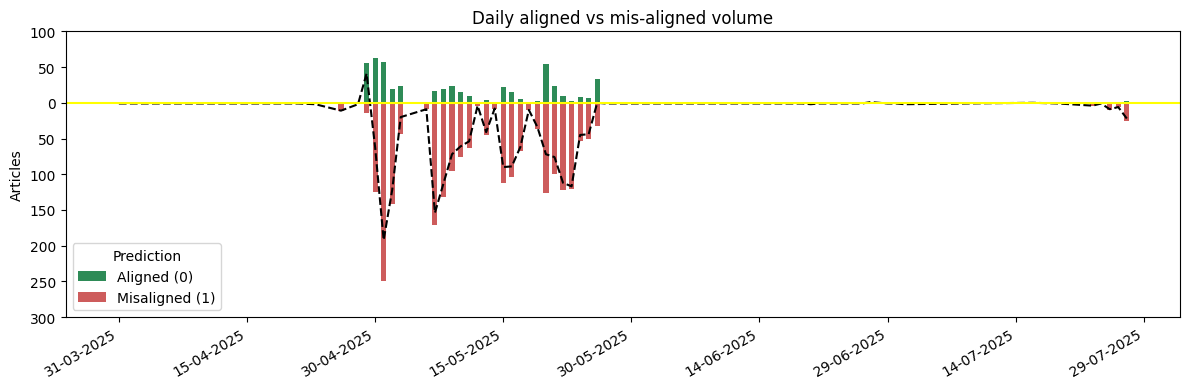

In [ ]:





# 6‑B. Plot daily aligned vs misaligned volume (diverging bar chart)
# --------------------------------------------------------------------------
meta = load_dict(json_path)
# Reconstruct DataFrame from saved data
df_loaded = pd.DataFrame(meta["data"])
# Parse dates back to datetime and set as index
df_loaded["publish_date"] = pd.to_datetime(df_loaded["publish_date"], utc=True)
df_loaded = df_loaded.set_index("publish_date").sort_index()

# Create diverging bar chart
fig, ax = plt.subplots(figsize=(12, 4))
bar_width = 0.6  # bar width (in days)
# Bars: aligned above x-axis, misaligned below (as negative values)
ax.bar(df_loaded.index, df_loaded["aligned"], width=bar_width,
       color=meta["color_map"]["aligned"], label="Aligned (0)")
ax.bar(df_loaded.index, -df_loaded["misaligned"], width=bar_width,
       color=meta["color_map"]["misaligned"], label="Misaligned (1)")

# Plot difference line and baseline at 0
diff = df_loaded["aligned"] - df_loaded["misaligned"]
ax.plot(df_loaded.index, diff, color="black", linestyle="--")
ax.axhline(0, color="yellow")

# Title, labels, and legend
ax.set_title(meta["title"])
ax.set_ylabel("Articles")
locator   = mdates.DayLocator(interval=15)
formatter = mdates.DateFormatter("%d-%m-%Y")
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
fig.autofmt_xdate()  # rotate date labels for readability

# Use absolute values for y-axis ticks (so negative shows as positive count)
yticks = ax.get_yticks()
ax.set_yticks(yticks)
ax.set_yticklabels([int(abs(t)) for t in yticks])

ax.legend(title="Prediction")
plt.tight_layout()
plt.show()
